# Parition function of classical 2D stat-mech model

2D Ferromagnetic Ising model

    H = -\sum_{\langle ij \rangle} \sigma_i \sigma_j

Partition function - sum of Boltzman weights for all configurations

    Z(\beta) = \sum_{\mathbf{\sigma}} exp(-\Beta H) = \sum_{\mathbf{\sigma}} \prod_{\langle ij \rangle} exp(\Beta \sigma_i \sigma_j)
    
Partition function = contraction of a tensor network

    x--h--x--h--x--h--x
    |     |     |     |
    h     h     h     h
    |     |     |     |
    x--h--x--h--x--h--x
    |     |     |     |
    h     h     h     h
    |     |     |     |
    x--h--x--h--x--h--x
    
where rank-2 tensor h<=>exp(\Beta \sigma_i \sigma_j) is a Boltzman weight located on the edge between two neighbouring Ising spins ij 
and x<=>\delta_{uldr} is a rank-4 tensor enforcing the same Ising spin state to enter the Boltzman weights on the adjacent edges.

By writing out h=\sqrt(h)\sqrt(h), i.e. as two weights with temperature \Beta/2, on each edge and absorbing these weights symmetrically
into x's on each vertex we get familiar PEPS form

                |
              \sqrt(h)   
                |                 |
    --\sqrt(h)--x--\sqrt(h)-- = --A--
                |                 |
             \sqrt(h)
                |

The partition function Z(A(\beta)) is given by the contraction

    A--A--A
    A--A--A
    A--A--A

In [1]:
# import numpy as np
import numpy as np
import scipy.linalg

transpose= np.transpose
einsum=np.einsum
argsort= lambda x: np.argsort(x)[::-1]
diag= np.diag
eigvalsh= np.linalg.eigvalsh

## i) On-site tensor

Define on-site tensor A that generates the PEPS corresponding to partition function Z

In [2]:
sigma= np.asarray([1,-1])
x= np.zeros((2,2,2,2))
x[0,0,0,0]=x[1,1,1,1]=1

def f_sqrth(beta):
    r"""
    Square root of rank-2 Boltzman weight from Ising interaction
    """
    return scipy.linalg.sqrtm(np.exp(beta*np.tensordot(sigma,sigma,([],[]))).reshape(sigma.shape*2))
    
def f_A(beta):
    r"""
    On-site tensor A generating the partition function Z(\Beta)
    """
    h= f_sqrth(beta)
    return np.einsum('ux,ly,dz,rw,xyzw->uldr',h,h,h,h,x)

## ii) Build initial CTM boundary 

Consider two options for initial boundary

Option a): Initial C,T are created from Boltzman weights on the open-boundary edges 
              
    C-- = x--\sqrt(h)
    |     |
          \sqrt(h) 
        
    --T-- = \sqrt(h)--x--\sqrt(h)
      |               | 
                     \sqrt(h)
                     
Option b): Take random (symmetric) C,T

In [3]:
def init_obc_CT(beta,chi):
    r"""
    Build initial boundaries from Boltzman weights of open boundary system
    """
    h=f_sqrth(beta)
    x_C= np.eye(2)
    C=np.zeros((chi,chi))
    C[:2,:2]=np.einsum('dx,ry,xy->dr',h,h,x_C)
    
    x_T= np.zeros((2,2,2))
    x_T[0,0,0]=x_T[1,1,1]=1
    T=np.zeros((chi,chi,2))
    T[:2,:2,:]=np.einsum('lx,dy,rz,xyz->lrd',h,h,h,x_T)
    return C,T

def init_rand_CT(A,chi):
    r"""
    Build random initial boundaries C, T
    """
    C=np.random.rand(chi,chi)
    C=C+transpose(C,(1,0))
    T=np.random.rand(chi,chi,2)
    T=T+transpose(T,(1,0,2))
    return C,T

## iii) The CTMRG move

First, enlarge the system

    C_i--T_i--C_i      C_i--T_i--T_i--T_i--C_i
    T_i--A----T_i  =>  T_i--A----A----A----C_i
    C_i--T_i--C_i      T_i--A----A----A----C_i
                       T_i--A----A----A----C_i
                       C_i--T_i--T_i--T_i--C_i

### iii.1) Expand
Define and accumulate enlarged quadrant of the system into enlarged corner tensor
of size (\chi*D)^2

    C_i--T_i-- = C'_i==
    |    |       ||
    T_i--A----
    |    |
    
Afterwards, compute its optimal compression up to rank \chi and retrieve corresponding projectors

    C'== =  U'--D'--U'^\dag==  => compress =>  U--\chi--D--\chi--U^\dag==    
    ||      ||                                 ||

In [4]:
def enlarged_C(A,C,T):
    r"""
    Build enlarged corner tensor
    
        C----1 1(0)---T--2(1) = C'==2,7
        0             3(2)      ||
        0(1)          3(0)      4,6
        T--5(2) 5(1)--A--7(3)
        4(0)          6(2) 
    """
    return einsum(C,(0,1),T,(1,2,3),T,(4,0,5),A,(3,5,6,7),(4,6,2,7))

def compress(chi,C):
    r"""
    Compute optimal projectors U, which compress C' to at most rank-\chi corner tensor C
    """
    D,U= np.linalg.eigh(C.reshape(C.shape[0]*C.shape[1],C.shape[2]*C.shape[3]))
    
    # reorder by magnitude
    ind=argsort(np.abs(D))
    D= D[ind[:chi]]
    U= U[:,ind[:chi]].reshape(C.shape[0],C.shape[1],chi)
    return D,U

### iii.2) Absorb

Renormalize the network, be absorbing and compressing enlarged corners and half-row/-column transfer matrices

    C_i--T_i--T_i--T_i--C_i      C_{i+1}--T_{i+1}--C_{i+1}     
    T_i--A----A----A----C_i  =>  T_{i+1}--A--------T_{i+1}
    T_i--A----A----A----C_i      C_{i+1}--T_{i+1}--C_{i+1} 
    T_i--A----A----A----C_i
    C_i--T_i--T_i--T_i--C_i

Using optimal projectors, extend half-row/-column transfer matrix and compress it

                                     |
                                     U
    |    |     ||                    ||       |
    T_i--A-- = T'_i-- => compress => T'_i-- = T_{i+1}
    |    |     ||                    ||       |
                                     U^\dag
                                     |

In [5]:
def absorb(A,T,U):
    r"""
    Aborb and compress half-row/-column tensor given optimal projector of enlarged corner
    
        4(2)
        U
        |---------\   
        1(0)       3(1)
        1          3(0)      1
        T--2 2(1)--A--6(3) = T--2
        0          5(2)      0
        0          5(1)
        |----------/
        U^\dag
        7(2)
    """
    return einsum(T,(0,1,2),U,(1,3,4),A,(3,2,5,6),U.conj(),(0,5,7),(7,4,6))

### iii.3) Compose enlarge, compress, and absorb operations into a full CTM move

The compressed corner is given by leading-chi kept eigenvalues C_{i+1} of enlarged corner

In [6]:
def ctm_iter(A,C,T,chi):
    r"""
    Performs a single CTM interation renormalizing the boundary tensors
    to environment dimension \chi
    """
    D,U= compress(chi, enlarged_C(A,C,T))
    C_n= diag(D)
    T_n= absorb(A,T,U)
    return C_n,T_n

## iv) CTMRG algorithm

The CTMRG algorithm requires an initial choice of the boundary tensors.
Afterwards, it is iterated until the fixed point is reached.

* Normalize numerical values of the boundary tensors by making magnitude of the largest element equal to 1.
* To establish convergence, let's use spectra of the corners.

In [7]:
def ctmrg(A,C,T,chi,ctm_max_iter=100,ctm_conv_tol=1.0e-8,callback=None):
    r"""
    Return a fixed point of CTMRG process for PEPS generated by tensor A with initial boundaries C,T
    """
    # setup
    # spectrum of initial corner
    s_i= eigvalsh(C)
    inds=argsort(s_i)
    s_i=s_i[inds]/abs(s_i).max()
    
    # main ctmrg loop
    for i in range(ctm_max_iter):
        C,T= ctm_iter(A,C,T,chi)
        
        # normalize numerical values of boundary tensors by making magnitude of largest element equal to 1
        # and symmetrize T tensor (suppres finite-precision error)
        C= C/abs(C).max()
        T= T+transpose(T,(1,0,2))
        T= T/abs(T).max()
        
        # check convergence
        inds=argsort(diag(C))
        conv_crit= abs(diag(C)[inds]-s_i).sum()
        
        # (optional) monitor through callback
        if callback: callback(i,conv_crit,(conv_crit < ctm_conv_tol) or i==ctm_max_iter-1,A,C,T)
        if conv_crit < ctm_conv_tol: break
        s_i= diag(C)[inds]
        
    return C,T

## v) Evaluate on-site observable: magnetization

Thermal expectation value of magnetization is given as

    m = \langle \sigma \rangle = Tr[\sigma exp(-\Beta H)] / Z(\Beta)
    
which can be reinterpreted as a ratio of two tensor networks, which we approximate
through converged boundary tensors
          
              ...              ...
           A--A--A     /  ..A--A--A..          CTC   / CTC
    m = ...A--B--A..  /   ..A--A--A.. \approx  TBT  /  TAT
           A--A--A   /    ..A--A--A            CTC /   CTC
              ...              ...
          
where tensor B carries an on-site observable, \sigma         

In [8]:
def f_B(beta):
    r"""
    On-site tensor B carrying, obtained from A by modifying the weights with observable \sigma
    """
    h= f_sqrth(beta)
    return np.einsum('ux,ly,dz,rw,xyzw,x->uldr',h,h,h,h,x,sigma)

def aux_rho_1x1(C,T):
    r"""
    Build environment of single site
    
        i) C--1 1(0)--T--2(1) = C--T--1
           0          3(2)      0  2

        ii) C--T--1 1(0)--C   = C--T-----C
            0  2          |     0  2  3--T
                    4(2)--T              1
                          3(1)

        iii) C------T-------C
             0      2       |
             0(1)           |
             T---4(3)    3--T
             |              1
             |      5(2)    1(0)
             C------T-------C       
    """
    rho=einsum(C,(0,1),T,(1,2,3),(0,2,3))
    rho=einsum(rho,(0,1,2),rho,(1,3,4),(0,3,2,4))
    rho=einsum(rho,(0,1,2,3),rho,(1,0,5,4),(2,4,5,3))
    return rho

def eval_1x1(B,A,rho):
    r"""
    Given 1x1 environment rho, compute the normalized expectation value 
    of on-site tensor B
    """
    return einsum('uldr,uldr',rho,B)/einsum('uldr,uldr',rho,A)

## vi) Wrap everything up to compute phase diagram

The exact solution gives critical temperature and magnetization profile

    \Beta_c = log(1 + \sqrt(2))/2
    
    m=(1-[sinh(2)]^{-4})^{1/8}
    
Pick environment dimension \chi and compute magnetization profile for a range of \Beta

(Tip: use randomly initialized environments. What happens if you instead use one generated from Boltzman weights ?) 


In [ ]:
chi=8

betas=np.linspace(0.1,0.6,20)
ms=[]
spec_C=[]

for beta in betas:
    A= f_A(beta)
    C,T= ctmrg(A,*init_rand_CT(beta,chi),chi,ctm_max_iter=1000,ctm_conv_tol=1.0e-8,
               callback=(lambda i,conv_crit,conv,_A,_C,_T: print(f"{beta} {i} {conv_crit} {_C.diagonal()}") if conv else None))
    
    m= eval_1x1(f_B(beta),A,aux_rho_1x1(C,T))
    
    ms.append(m)

/tmp/ipykernel_2004/227043601.py:6: RuntimeWarning: invalid value encountered in power
  ax[0].plot(np.linspace(np.min(betas),np.max(betas),100), np.nan_to_num((1-np.sinh(2*np.asarray(np.linspace(np.min(betas),np.max(betas),100)))**(-4))**(1/8)),color="black")
/tmp/ipykernel_2004/227043601.py:7: RuntimeWarning: invalid value encountered in power
  ax[1].scatter(betas, abs(np.asarray(ms))-np.nan_to_num((1-np.sinh(2*np.asarray(betas))**(-4))**(1/8)) )


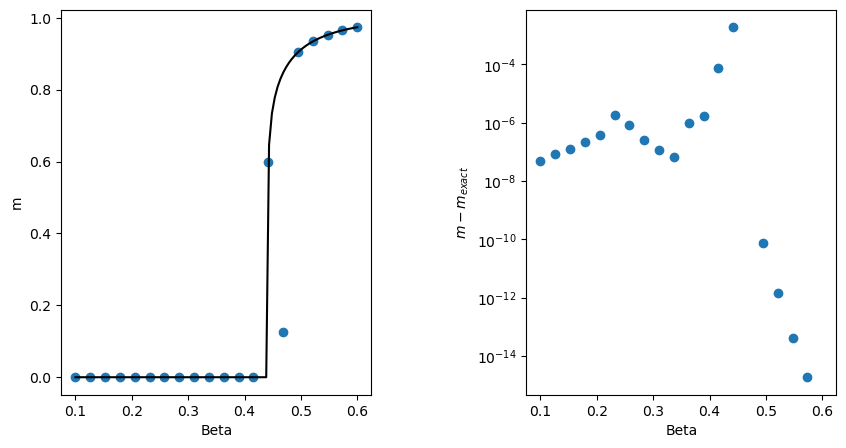

In [13]:
import matplotlib.pyplot as plt

# plot
fig, ax = plt.subplots(1,2,figsize=(10, 5),gridspec_kw={'wspace': 0.5})
ax[0].scatter(betas, abs(np.asarray(ms)))
ax[0].plot(np.linspace(np.min(betas),np.max(betas),100), np.nan_to_num((1-np.sinh(2*np.asarray(np.linspace(np.min(betas),np.max(betas),100)))**(-4))**(1/8)),color="black")
ax[1].scatter(betas, abs(np.asarray(ms))-np.nan_to_num((1-np.sinh(2*np.asarray(betas))**(-4))**(1/8)) )

ax[0].set_xlabel(r"Beta")
ax[0].set_ylabel(r"m")

ax[1].set_xlabel(r"Beta")
ax[1].set_ylabel(r"$m-m_{exact}$")
ax[1].set_yscale('log')

plt.show()

## vii) What about correlation lengths ?

Compute PEPS correlation length from the leading part of the spectrum of widht-1 PEPS transfer matrix

    --T--
    --A-- = \sum_i \lambda_i |v_i><v_i|
    --T--

In [29]:
from scipy.sparse.linalg import LinearOperator, eigs

def xi(A,T,n=2,v0=None):
    r"""
    Compute leading n-eigenvalues of width-1 transfer operator
    
    Use dominant eigensolver supplying a matrix-vector operation
    
      --0(chi) 0-----T--3(1)     ---0
     |               4(2)       |
     |               4(0)       |
     v--1(D) 1(1)----A---6(3) = v'--1
     |               5(2)       |
     |               5(2)       |
      --2(chi) 2(1)--T--7(0)     ---2
    """
    def _mv(v):
        v= v.reshape(T.shape[0],A.shape[1],T.shape[1])
        v= np.einsum(v,(0,1,2),T,(0,3,4),A,(4,1,5,6),T,(7,2,5),(3,6,7))
        v= v.reshape(T.shape[0]*A.shape[1]*T.shape[1])
        return v

    Tw1= LinearOperator((T.shape[0]*A.shape[1]*T.shape[1],)*2, matvec=_mv)
    vals= eigs(Tw1, k=n, v0=v0, return_eigenvectors=False)

    # post-process
    ind_sorted= np.argsort(np.abs(vals))[::-1] # descending order
    vals= vals[ind_sorted]
    vals= (1.0/np.abs(vals[0])) * vals
    
    return -1./np.log(np.abs(vals[1])), vals

In [ ]:
chi=16

betas=np.linspace(0.1,0.6,20)
ms=[]
xis=[]

for beta in betas:
    A= f_A(beta)
    C,T= ctmrg(A,*init_rand_CT(beta,chi),chi,ctm_max_iter=1000,ctm_conv_tol=1.0e-8,
               callback=(lambda i,conv_crit,conv,_A,_C,_T: print(f"{beta} {i} {conv_crit} {_C.diagonal()}") if conv else None))
    
    m= eval_1x1(f_B(beta),A,aux_rho_1x1(C,T))
    
    ms.append(m)
    xi_,spec= xi(A,T,n=2)
    xis.append(xi_)

/tmp/ipykernel_1195/240297457.py:6: RuntimeWarning: invalid value encountered in power
  ax[0].plot(np.linspace(np.min(betas),np.max(betas),100), np.nan_to_num((1-np.sinh(2*np.asarray(np.linspace(np.min(betas),np.max(betas),100)))**(-4))**(1/8)),color="black")
/tmp/ipykernel_1195/240297457.py:10: RuntimeWarning: invalid value encountered in power
  ax[1].scatter(betas, abs(np.asarray(ms))-np.nan_to_num((1-np.sinh(2*np.asarray(betas))**(-4))**(1/8)) )


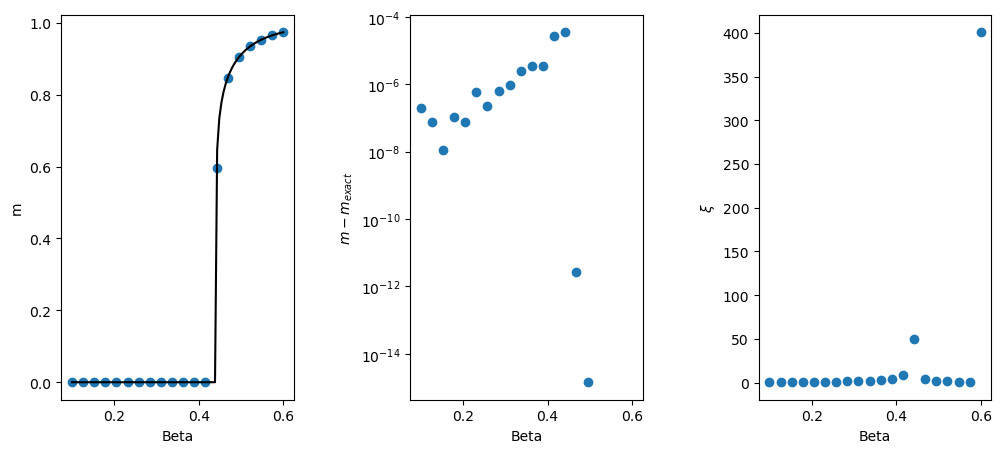

In [39]:
import matplotlib.pyplot as plt

# plot
fig, ax = plt.subplots(1,3,figsize=(12, 5),gridspec_kw={'wspace': 0.5})
ax[0].scatter(betas, abs(np.asarray(ms)))
ax[0].plot(np.linspace(np.min(betas),np.max(betas),100), np.nan_to_num((1-np.sinh(2*np.asarray(np.linspace(np.min(betas),np.max(betas),100)))**(-4))**(1/8)),color="black")
ax[0].set_xlabel(r"Beta")
ax[0].set_ylabel(r"m")

ax[1].scatter(betas, abs(np.asarray(ms))-np.nan_to_num((1-np.sinh(2*np.asarray(betas))**(-4))**(1/8)) )
ax[1].set_xlabel(r"Beta")
ax[1].set_ylabel(r"$m-m_{exact}$")
ax[1].set_yscale('log')

ax[2].scatter(betas, xis)
ax[2].set_xlabel(r"Beta")
ax[2].set_ylabel(r"$\xi$")

plt.show()